# Flattened dT analysis
Full combinatorics

In [1]:
# System tools  
import sys
from pathlib import Path
import warnings
warnings.filterwarnings("ignore") # suppress warnings

# Python stack 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import awkward as ak

# ML tools
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, roc_curve

# Internal modules 
sys.path.extend(["../../src/core", "../../src/utils"])
from draw import Draw
from io_manager import Load

# pyutils 
from pyutils.pyplot import Plot
plotter = Plot() # just use this for styles

[pyplot] ⭐️ Initialised Plot with mu2e.mplstyle and verbosity = 1


## Load data

In [2]:
!ls -ltrh ../../output/dt/

total 0
drwxr-xr-x. 3 sgrant fnalgrid 1 Dec  2 19:56 cosmic
drwxr-xr-x. 3 sgrant fnalgrid 1 Dec  2 20:00 test
drwxr-xr-x. 3 sgrant fnalgrid 1 Dec  2 20:10 a


In [3]:
!ls -ltrh ../../output/dt/a
!ls -ltrh ../../output/dt/a/data
!ls -ltrh ../../output/dt/a/data/*

total 0
drwxr-xr-x. 4 sgrant fnalgrid 2 Dec  2 20:14 data
total 0
drwxr-xr-x. 2 sgrant fnalgrid 4 Dec  2 20:14 CRY_onspill-LH_aw
drwxr-xr-x. 2 sgrant fnalgrid 4 Dec  2 20:18 CRY_mix2BB_onspill-LH_aw
../../output/dt/a/data/CRY_onspill-LH_aw:
total 5.6M
-rw-r--r--. 1 sgrant fnalgrid 3.8M Dec  2 20:14 results.pkl
-rw-r--r--. 1 sgrant fnalgrid 1.4K Dec  2 20:14 cut_flow.csv
-rw-r--r--. 1 sgrant fnalgrid 224K Dec  2 20:14 hists.h5
-rw-r--r--. 1 sgrant fnalgrid 1.7M Dec  2 20:14 events.parquet

../../output/dt/a/data/CRY_mix2BB_onspill-LH_aw:
total 11M
-rw-r--r--. 1 sgrant fnalgrid 7.5M Dec  2 20:18 results.pkl
-rw-r--r--. 1 sgrant fnalgrid 1.4K Dec  2 20:18 cut_flow.csv
-rw-r--r--. 1 sgrant fnalgrid 224K Dec  2 20:18 hists.h5
-rw-r--r--. 1 sgrant fnalgrid 2.8M Dec  2 20:18 events.parquet


In [9]:
run = "a"
base_in_path = Path(f"../../output/dt/{run}/data/")

# Load both test datasets
cry_path = base_in_path / "CRY_onspill-LH_aw/"
cry_mix2bb_path = base_in_path / "CRY_mix2BB_onspill-LH_aw/"

print(f"Loading CRY data from: {cry_path}")
cry_data = Load(in_path=cry_path).load_pkl()["events"]

print(f"Loading CRY mix2BB data from: {cry_mix2bb_path}")
cry_mix_data = Load(in_path=cry_mix2bb_path).load_pkl()["events"]

print(f"CRY events: {len(cry_data)}")
print(f"CRY mix2BB events: {len(cry_mix_data)}")

Loading CRY data from: ../../output/dt/a/data/CRY_onspill-LH_aw
[Load] ✅ Initialised with out_path=../../output/dt/a/data/CRY_onspill-LH_aw
[Load] ✅ Successfully loaded results from ../../output/dt/a/data/CRY_onspill-LH_aw/results.pkl
Loading CRY mix2BB data from: ../../output/dt/a/data/CRY_mix2BB_onspill-LH_aw
[Load] ✅ Initialised with out_path=../../output/dt/a/data/CRY_mix2BB_onspill-LH_aw
[Load] ✅ Successfully loaded results from ../../output/dt/a/data/CRY_mix2BB_onspill-LH_aw/results.pkl
CRY events: 23727
CRY mix2BB events: 48284


In [7]:
## Add duration
cry_data["duration"] = cry_data["timeEnd"] - cry_data["timeStart"]
cry_mix_data["duration"] = cry_mix_data["timeEnd"] - cry_mix_data["timeStart"]

## Verify data

In [8]:
from pyutils.pyprint import Print
printer = Print()
printer.print_n_events(cry_data, n_events=2)
printer.print_n_events(cry_mix_data, n_events=2)

[pyprint] ⭐️ Initialised Print with verbose = False and precision = 1
[pyprint] ⭐️ Printing 2 event(s)...

-------------------------------------------------------------------------------------
event: 430241.0
subrun: 95.0
run: 1202.0
dT: 95.65186950012503
crv_x: 563.35693359375
crv_y: 2706.025390625
crv_z: 3240.578857421875
PEs: 807.2415161132812
nHits: 16.0
nLayers: 4.0
angle: 0.3260249197483063
timeStart: 1139.365234375
timeEnd: 1214.365234375
crv_time: 1112.3841552734375
PEs_per_hit: 50.45259475708008
t0: 1208.0360247735625
d0: 96.78047180175781
tanDip: 0.5298436284065247
maxr: 589.1268920898438
mom_mag: 86.7626724243164
duration: 75.0
-------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------
event: 242861.0
subrun: 303.0
run: 1202.0
dT: 45.39353268890068
crv_x: 625.6521606445312
crv_y: 2710.683837890625
crv_z: -6735.23828125
PEs: 742.8091430664062
nHits: 16.0
nLayers: 

[pyplot] ⭐️ Initialised Plot with mu2e.mplstyle and verbosity = 1
	Wrote ../../../output/images/dt/veto/a/features/h1o_2x3_features.png


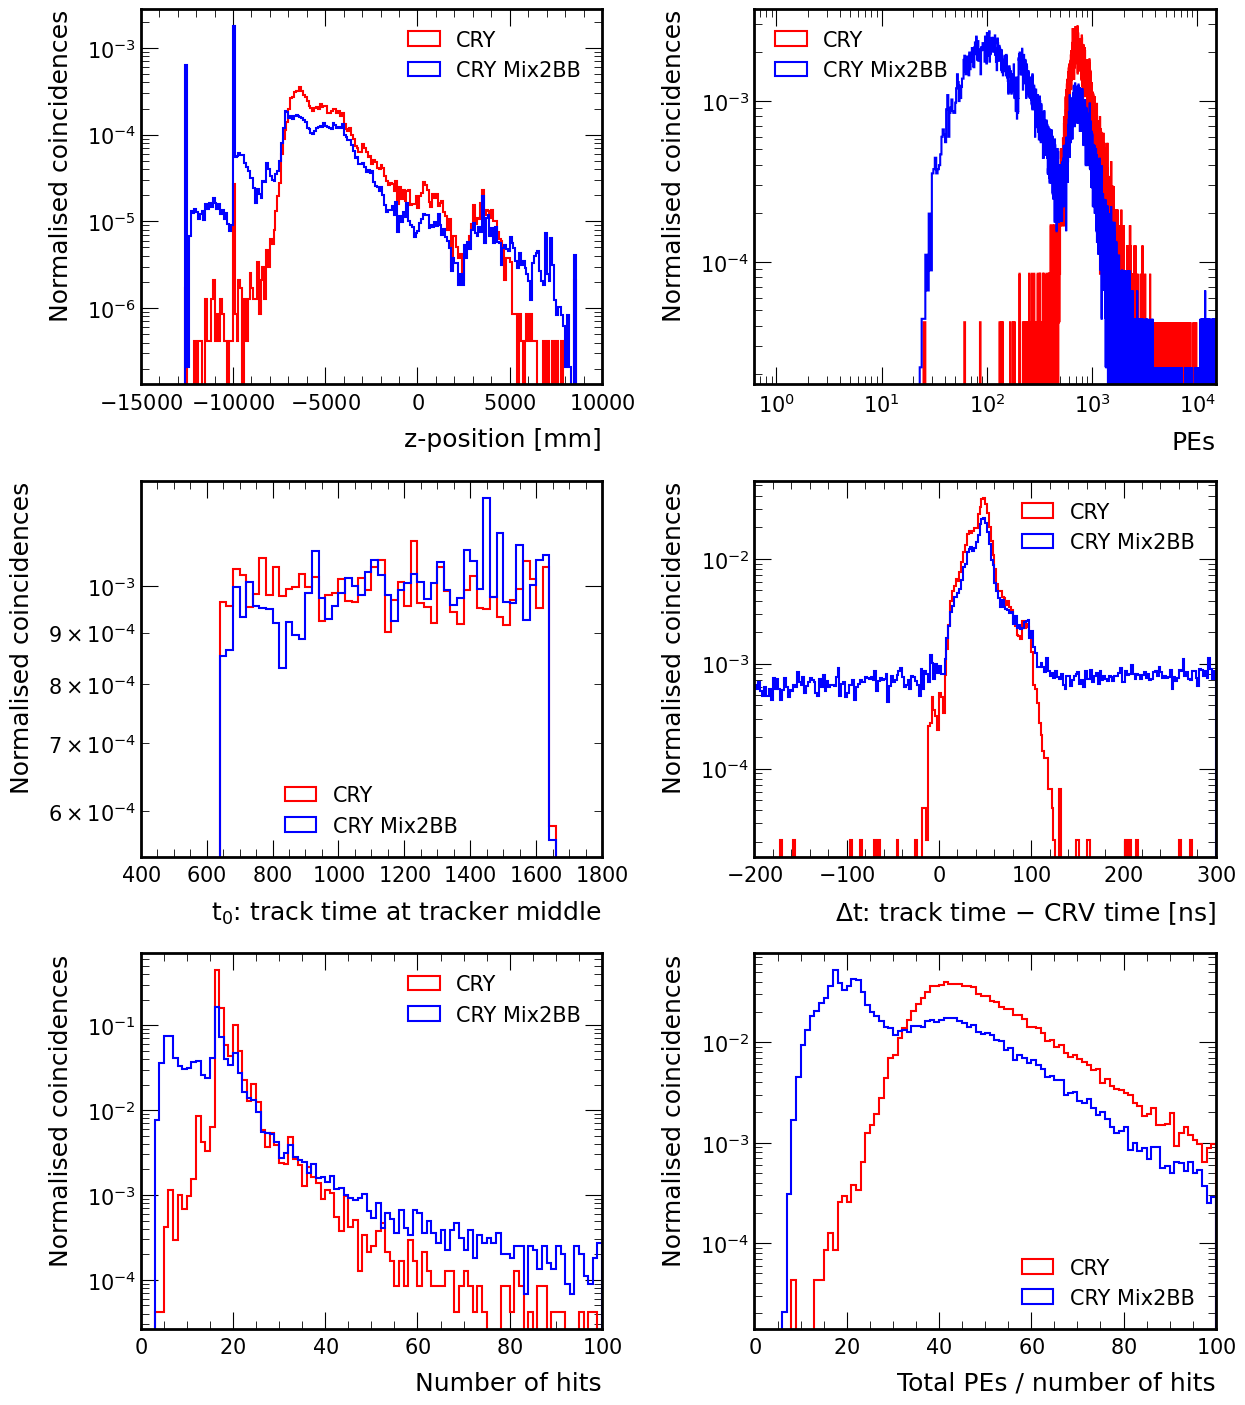

In [12]:
from pyutils.pyplot import Plot 
plotter = Plot()

fig, ax = plt.subplots(3, 2, figsize=(2*6.4, 3*4.8))

styles = {
    "CRY" : { 
        "color" : "red",# #0173B2"
        # "histtype" : "bar",
        # "alpha" : 0.4
    },
    "CRY Mix2BB" : {
        "color" : "blue", # "#FF6600"
        # "histtype" : "bar",
        # "alpha" : 0.4
    }
}

# Plot 1: CRV z-position
plotter.plot_1D_overlay(
    {
        "CRY" : ak.flatten(cry_data["crv_z"], axis=-1),
        "CRY Mix2BB": ak.flatten(cry_mix_data["crv_z"], axis=-1),
    },
    nbins=250,
    xmin=-15000,
    xmax=10000,
    show=False,
    ax=ax[0,0],
    log_y=True,
    xlabel="z-position [mm]", 
    ylabel="Normalised coincidences",
    norm_by_area=True,
    styles=styles
)

# Plot 2: CRV PEs
plotter.plot_1D_overlay(
    {
        "CRY" : ak.flatten(cry_data["PEs"], axis=-1),
        "CRY Mix2BB": ak.flatten(cry_mix_data["PEs"], axis=-1),
    },
    nbins=int(1.5e4),
    xmin=0,
    xmax=1.5e4,
    show=False,
    ax=ax[0,1],
    log_y=True,
    log_x=True,
    xlabel="PEs", 
    ylabel="Normalised coincidences",
    norm_by_area=True,
    styles=styles
)

# Plot 3: t0
plotter.plot_1D_overlay(
    {
        "CRY" : ak.flatten(cry_data["t0"], axis=-1),
        "CRY Mix2BB": ak.flatten(cry_mix_data["t0"], axis=-1),
    },
    nbins=70,
    xmin=400,
    xmax=1800,
    show=False,
    ax=ax[1,0],
    log_y=True,
    log_x=False,
    xlabel=r"$t_{0}$: track time at tracker middle", 
    ylabel="Normalised coincidences",
    norm_by_area=True,
    styles=styles
)

# Plot 4: dT
plotter.plot_1D_overlay(
    {
        "CRY" : ak.flatten(cry_data["dT"], axis=-1),
        "CRY Mix2BB": ak.flatten(cry_mix_data["dT"], axis=-1),
    },
    nbins=int(250),
    xmin=-200,
    xmax=300,
    show=False,
    ax=ax[1,1],
    log_y=True,
    log_x=False,
    xlabel=r"$\Delta t$: track time $-$ CRV time [ns]", 
    ylabel="Normalised coincidences",
    norm_by_area=True,
    styles=styles
)

# Plot 5: PEs per hit (new feature)
plotter.plot_1D_overlay(
    {
        "CRY" : ak.flatten(cry_data["PEs_per_hit"], axis=-1),
        "CRY Mix2BB": ak.flatten(cry_mix_data["PEs_per_hit"], axis=-1),
    },
    nbins=int(100),
    xmin=0,
    xmax=100,
    show=False,
    ax=ax[2,1],
    log_y=True,
    log_x=False,
    xlabel=r"Total PEs / number of hits", 
    ylabel="Normalised coincidences",
    norm_by_area=True,
    styles=styles
)

# Plot 6: Number of hits
plotter.plot_1D_overlay(
    {
        "CRY" : ak.flatten(cry_data["nHits"], axis=-1),
        "CRY Mix2BB": ak.flatten(cry_mix_data["nHits"], axis=-1),
    },
    nbins=int(100),
    xmin=0,
    xmax=100,
    show=False,
    ax=ax[2,0],
    log_y=True,
    log_x=False,
    xlabel=r"Number of hits", 
    ylabel="Normalised coincidences",
    norm_by_area=True,
    styles=styles
)

plt.tight_layout()

img_base_path = Path(f"../../../output/images/dt/veto/{run}/")
img_feature_out_path = img_base_path / "features"
img_feature_out_path.mkdir(exist_ok=True, parents=True)
out_name = img_feature_out_path / "h1o_2x3_features.png"

plt.savefig(out_name)
print(f"\tWrote {out_name}")
plt.show()

In [11]:
# !touch ../../../output/images/ml/veto/hello

	Wrote ../../../output/images/dt/veto/a/features/h2o_dT_vs_z.png


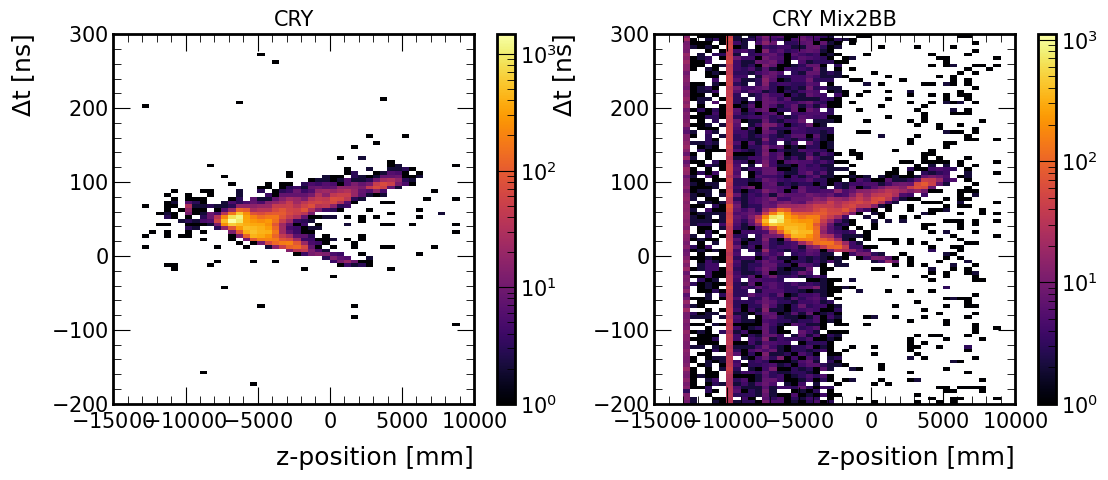

In [13]:
fig, ax = plt.subplots(1,2,figsize=(2*6.4, 4.8))
plotter.plot_2D(
    x = ak.flatten(cry_data["crv_z"], axis=-1),
    y = ak.flatten(cry_data["dT"], axis=-1),
    nbins_x=50,
    xmin=-15000,
    xmax=10000,
    nbins_y=100,
    ymin=-200,
    ymax=300,
    show=False,
    log_z=True,
    xlabel="z-position [mm]", 
    ylabel=r"$\Delta t$ [ns]", 
    title="CRY",
    ax=ax[0]
)
plotter.plot_2D(
    x = ak.flatten(cry_mix_data["crv_z"], axis=-1),
    y = ak.flatten(cry_mix_data["dT"], axis=-1),
    nbins_x=50,
    xmin=-15000,
    xmax=10000,
    nbins_y=100,
    ymin=-200,
    ymax=300,
    show=False,
    log_z=True,
    xlabel="z-position [mm]", 
    ylabel=r"$\Delta t$ [ns]", 
    title="CRY Mix2BB",
    ax=ax[1]
)

# img_base_path = Path(f"../../../output/images/ml/veto/{run}/xgboost")
# model_out_path = Path(f"../../../output/ml/veto/{run}/models/xgboost/features")
# img_out_path.mkdir(exist_ok=True, parents=True)
out_name = img_feature_out_path / "h2o_dT_vs_z.png"

plt.savefig(out_name)
print(f"\tWrote {out_name}")
# plt.show()